In [0]:
%matplotlib inline


Spatial Transformer Networks Tutorial
=====================================
**Author**: `Ghassen HAMROUNI <https://github.com/GHamrouni>`_

![image.png](https://pytorch.org/tutorials/_images/FSeq.png)

In this tutorial, you will learn how to augment your network using
a visual attention mechanism called spatial transformer
networks. You can read more about the spatial transformer
networks in the [DeepMind paper](https://arxiv.org/abs/1506.02025)

Spatial transformer networks are **a generalization of differentiable
attention to any spatial transformation**. Spatial transformer networks
(STN for short) allow a neural network to **learn how to perform spatial
transformations on the input image in order to enhance the geometric
invariance of the model**.
For example, it can crop a region of interest, scale and correct
the orientation of an image. It can be a useful mechanism because CNNs
are not invariant to rotation and scale and more general affine
transformations.

One of the best things about STN is the ability to simply plug it into
any existing CNN with very little modification.



In [0]:
# License: BSD
# Author: Ghassen Hamrouni

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

plt.ion()   # interactive mode

Loading the data
----------------

In this post we experiment with the classic MNIST dataset. Using a
standard convolutional network augmented with a spatial transformer
network.



In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training dataset
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])), batch_size=64, shuffle=True, num_workers=4)
# Test dataset
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=64, shuffle=True, num_workers=4)

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Depicting spatial transformer networks
--------------------------------------

Spatial transformer networks boils down to three main components :

-  The localization network is a regular CNN which regresses the
   transformation parameters. The transformation is never learned
   explicitly from this dataset, instead the network learns automatically
   the spatial transformations that enhances the global accuracy.
-  The grid generator generates a grid of coordinates in the input
   image corresponding to each pixel from the output image.
-  The sampler uses the parameters of the transformation and applies
   it to the input image.

![image.png](https://pytorch.org/tutorials/_images/stn-arch.png)

.. Note::
   We need the latest version of PyTorch that contains
   affine_grid and grid_sample modules.




In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 3 * 3)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        # transform the input
        x = self.stn(x)

        # Perform the usual forward pass
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


model = Net().to(device)

Training the model
------------------

Now, let's use the SGD algorithm to train the model. The network is
learning the classification task in a supervised way. In the same time
the model is learning STN automatically in an end-to-end fashion.



In [0]:
optimizer = optim.SGD(model.parameters(), lr=0.01)


def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
#
# A simple test procedure to measure STN the performances on MNIST.
#


def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))

Visualizing the STN results
---------------------------

Now, we will inspect the results of our learned visual attention
mechanism.

We define a small helper function in order to visualize the
transformations while training.



In [0]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

# We want to visualize the output of the spatial transformers layer
# after the training, we visualize a batch of input images and
# the corresponding transformed batch using STN.


def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = convert_image_np(torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

In [7]:
for epoch in range(1, 20 + 1):
    train(epoch)
    test()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3289: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3226: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.305253
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.799011


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.2026, Accuracy: 9440/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.451288
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.469625

Test set: Average loss: 0.1084, Accuracy: 9673/10000 (97%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.240407
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.075150

Test set: Average loss: 0.1757, Accuracy: 9473/10000 (95%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.203181
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.080646

Test set: Average loss: 0.1744, Accuracy: 9457/10000 (95%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.606915
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.288987

Test set: Average loss: 0.0630, Accuracy: 9815/10000 (98%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.076881
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.176750

Test set: Average loss: 0.0591, Accuracy: 9814/10000 (98%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.152288
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.105266

Test set: Average loss: 0.0541, Accuracy: 9834/10000 (98%)

Tra

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3289: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3226: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


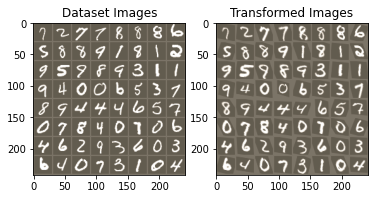

In [8]:
# Visualize the STN transformation on some input batch
visualize_stn()

plt.ioff()
plt.show()

# Changement de Transformation

In [0]:
# Training dataset
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.RandomAffine(25, translate=(0.2,0.2), scale=(1,2), shear=10, resample=False, fillcolor=0),
                       transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))
                   ])), batch_size=64, shuffle=True, num_workers=4)

# Test dataset
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=False, transform=transforms.Compose([
                transforms.RandomAffine(25, translate=(0.2,0.2), scale=(1,2), shear=10, resample=False, fillcolor=0),
                transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=64, shuffle=True, num_workers=4)

In [10]:
for epoch in range(1, 20 + 1):
    train(epoch)
    test()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3289: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3226: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Train Epoch: 1 [0/60000 (0%)]	Loss: 3.924816
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.962581


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.4857, Accuracy: 8520/10000 (85%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.843994
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.666359

Test set: Average loss: 0.3693, Accuracy: 8882/10000 (89%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.862618
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.679532

Test set: Average loss: 0.3448, Accuracy: 8944/10000 (89%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.629446
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.759761

Test set: Average loss: 0.3493, Accuracy: 8963/10000 (90%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.666683
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.451802

Test set: Average loss: 0.3086, Accuracy: 9056/10000 (91%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.679062
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.808386

Test set: Average loss: 0.3016, Accuracy: 9063/10000 (91%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.508742
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.449182

Test set: Average loss: 0.2986, Accuracy: 9070/10000 (91%)

Tra

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3289: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3226: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


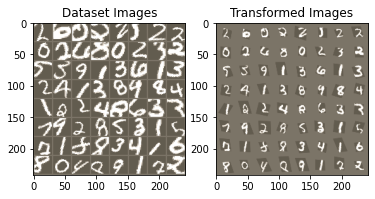

In [11]:
# Visualize the STN transformation on some input batch
visualize_stn()

plt.ioff()
plt.show()

# Pas de Transformation

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    def forward(self, x):
        # Perform the usual forward pass
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


model = Net().to(device)

In [22]:
for epoch in range(1, 20 + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.334694
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.287692


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 2.3037, Accuracy: 1118/10000 (11%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.307767
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.320148

Test set: Average loss: 2.3040, Accuracy: 1107/10000 (11%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 2.304817
Train Epoch: 3 [32000/60000 (53%)]	Loss: 2.303848

Test set: Average loss: 2.3038, Accuracy: 1099/10000 (11%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 2.328858
Train Epoch: 4 [32000/60000 (53%)]	Loss: 2.293503

Test set: Average loss: 2.3037, Accuracy: 1103/10000 (11%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 2.318299
Train Epoch: 5 [32000/60000 (53%)]	Loss: 2.299412

Test set: Average loss: 2.3039, Accuracy: 1042/10000 (10%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 2.313163
Train Epoch: 6 [32000/60000 (53%)]	Loss: 2.319977

Test set: Average loss: 2.3030, Accuracy: 1124/10000 (11%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 2.293384
Train Epoch: 7 [32000/60000 (53%)]	Loss: 2.322716

Test set: Average loss: 2.3045, Accuracy: 1094/10000 (11%)

Tra

**On remarque que la Loss ne diminue pas pour le CNN sans transformation**
